In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle as pkl
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [38]:
# Load dataset
dataset_dir = "dataset"

In [39]:
# Get image size from the first image
first_image_file = os.listdir(f"{dataset_dir}/Non Demented")[0]
img = plt.imread(f"{dataset_dir}/Non Demented/{first_image_file}")

img_height, img_width, _ = img.shape

img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}")

Image size: 248x496 -> 248


In [40]:
# Set batch size
batch_size = 16

#### General preprocessing and augmentation

In [65]:
# Using Tensor image generator to load train-test generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # horizontal_flip=True,
    validation_split=0.1,
)

train_generator = datagen.flow_from_directory(dataset_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = datagen.flow_from_directory(dataset_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

Found 8540 images belonging to 4 classes.
Found 948 images belonging to 4 classes.


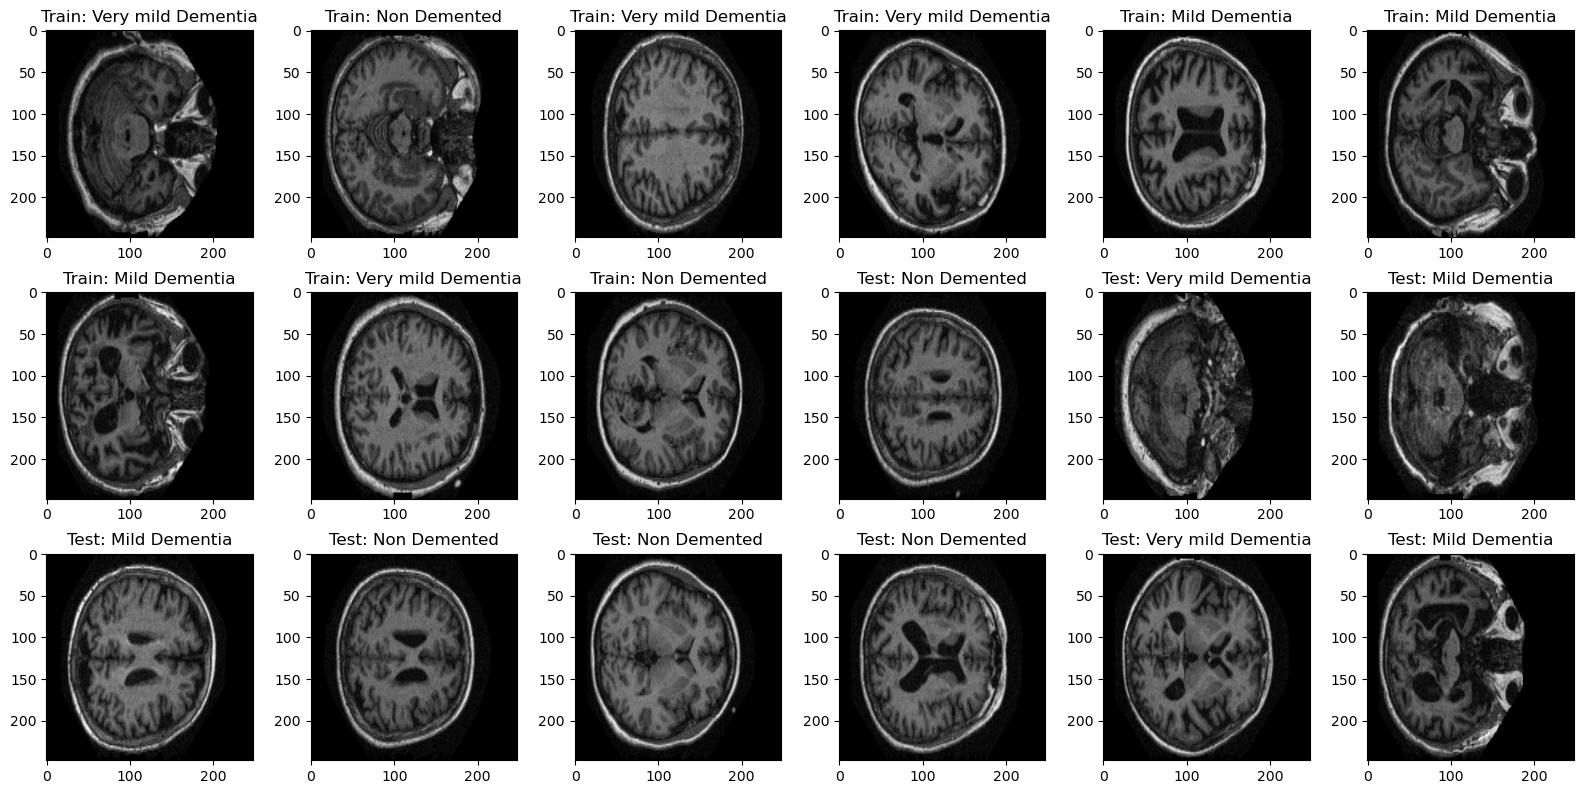

In [66]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(16, 8))

# Display sample training images
for i in range(9):
    plt.subplot(3, 6, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Train: " + class_labels[np.argmax(label)])
        break

# Display sample test images
for i in range(9):
    plt.subplot(3, 6, i + 10)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Test: " + class_labels[np.argmax(label)])
        break

plt.tight_layout()
plt.show()

#### Custom preprocessing and augmentation

In [67]:
def adjust_contrast(img):
    return tf.image.adjust_contrast(img, contrast_factor=2)

def sharpen_image(image):
    filter = tf.constant([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=tf.float32)
    filter = tf.reshape(filter, [3, 3, 1, 1])
    image = tf.expand_dims(image, axis=-1)
    sharpened_image = tf.nn.conv2d(image, filter, strides=[1, 1, 1, 1], padding="SAME")
    
    alpha = 0.9
    image = alpha * image + (1 - alpha) * sharpened_image
    
    return image[..., 0]

def prep_image(img):
    img = tf.image.rgb_to_grayscale(img)
    img = adjust_contrast(img)
    img = sharpen_image(img)
    img = tf.image.grayscale_to_rgb(img)
    return img

# Using Tensor image generator to load train-test generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # horizontal_flip=True,
    preprocessing_function=prep_image,
    validation_split=0.1,
)

train_generator = datagen.flow_from_directory(dataset_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = datagen.flow_from_directory(dataset_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

Found 8540 images belonging to 4 classes.
Found 948 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

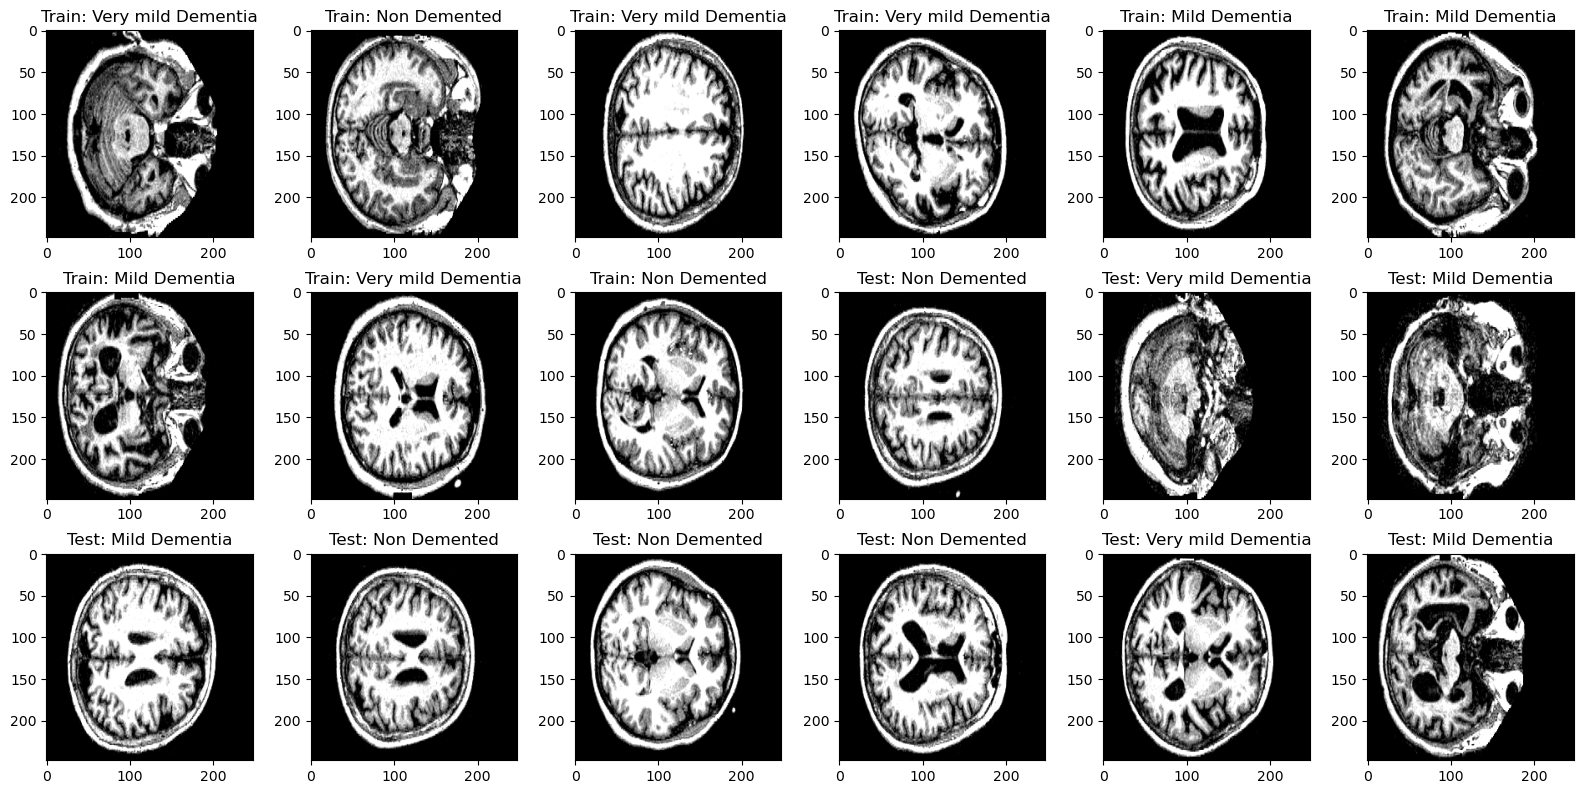

In [68]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(16, 8))

# Display sample training images
for i in range(9):
    plt.subplot(3, 6, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Train: " + class_labels[np.argmax(label)])
        break

# Display sample test images
for i in range(9):
    plt.subplot(3, 6, i + 10)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        label = Y_batch[0]
        plt.imshow(image)
        plt.title("Test: " + class_labels[np.argmax(label)])
        break

plt.tight_layout()
plt.show()

In [43]:
# Number of classes
num_classes = len(class_labels)

In [44]:
# Set number of epochs
epochs_number = 100

#### Score metrics

In [45]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall


# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision


# def specificity_m(y_true, y_pred):
#     true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
#     possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
#     specificity = true_negatives / (possible_negatives + K.epsilon())
#     return specificity


# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [46]:
# Compile model
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10)

#### Testing ResNet-50 model


In [47]:
# Load the ResNet50 model
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_resNet_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_resNet_model.output
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Flatten(name="flatten")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
# x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

resnet_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [48]:
# Train model
resNet_history = resnet_model.fit(
    train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[early_stopping]
)

Epoch 1/100
533/533 [==============================] - 42s 75ms/step - loss: 0.9674 - accuracy: 0.5921 - val_loss: 1.4421 - val_accuracy: 0.3093
Epoch 2/100
533/533 [==============================] - 41s 76ms/step - loss: 0.6425 - accuracy: 0.7732 - val_loss: 1.7710 - val_accuracy: 0.3432
Epoch 3/100
533/533 [==============================] - 40s 75ms/step - loss: 0.5217 - accuracy: 0.8306 - val_loss: 1.9626 - val_accuracy: 0.3072
Epoch 4/100
533/533 [==============================] - 40s 75ms/step - loss: 0.5638 - accuracy: 0.8089 - val_loss: 2.2532 - val_accuracy: 0.3157
Epoch 5/100
533/533 [==============================] - 41s 76ms/step - loss: 0.4836 - accuracy: 0.8392 - val_loss: 1.7272 - val_accuracy: 0.3379
Epoch 6/100
533/533 [==============================] - 40s 74ms/step - loss: 0.4567 - accuracy: 0.8476 - val_loss: 1.9299 - val_accuracy: 0.3824
Epoch 7/100
533/533 [==============================] - 40s 76ms/step - loss: 0.4275 - accuracy: 0.8612 - val_loss: 2.2593 - val_ac

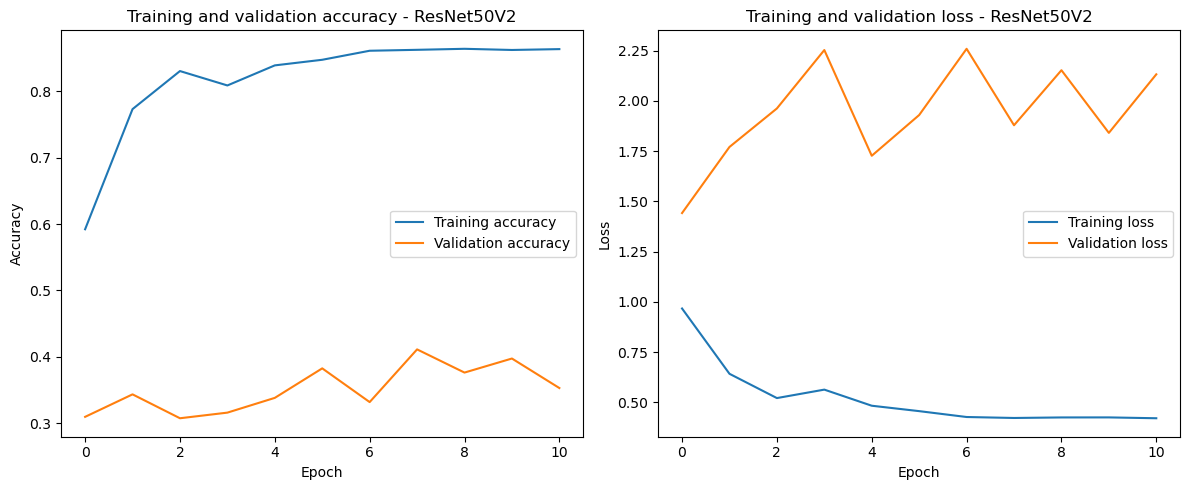

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [50]:
# Save trained model
resnet_model.save('resNet_model.h5')

# Save history
with open("resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

c:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### Testing DenseNet-121 model


In [51]:
# Load pre-trained DenseNet121 model
base_denseNet_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_denseNet_model.layers:
    layer.trainable = False
    
# Add custom classification head
x = base_denseNet_model.output
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Flatten(name="flatten")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
# x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
denseNet_model = Model(inputs=base_denseNet_model.input, outputs=predictions)

# Compile model
denseNet_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# denseNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [52]:
# Train model
denseNet_history = denseNet_model.fit(
    train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[early_stopping]
)

Epoch 1/100
533/533 [==============================] - 50s 83ms/step - loss: 1.2937 - accuracy: 0.3150 - val_loss: 1.2442 - val_accuracy: 0.3167
Epoch 2/100
533/533 [==============================] - 43s 80ms/step - loss: 1.2500 - accuracy: 0.3134 - val_loss: 1.2422 - val_accuracy: 0.3167
Epoch 3/100
533/533 [==============================] - 42s 80ms/step - loss: 1.2484 - accuracy: 0.3160 - val_loss: 1.2459 - val_accuracy: 0.3178
Epoch 4/100
533/533 [==============================] - 42s 79ms/step - loss: 1.2479 - accuracy: 0.3131 - val_loss: 1.2439 - val_accuracy: 0.3178
Epoch 5/100
533/533 [==============================] - 43s 80ms/step - loss: 1.2461 - accuracy: 0.3153 - val_loss: 1.2439 - val_accuracy: 0.3157
Epoch 6/100
533/533 [==============================] - 42s 79ms/step - loss: 1.2475 - accuracy: 0.3163 - val_loss: 1.2429 - val_accuracy: 0.3157
Epoch 7/100
533/533 [==============================] - 42s 79ms/step - loss: 1.2474 - accuracy: 0.3143 - val_loss: 1.2421 - val_ac

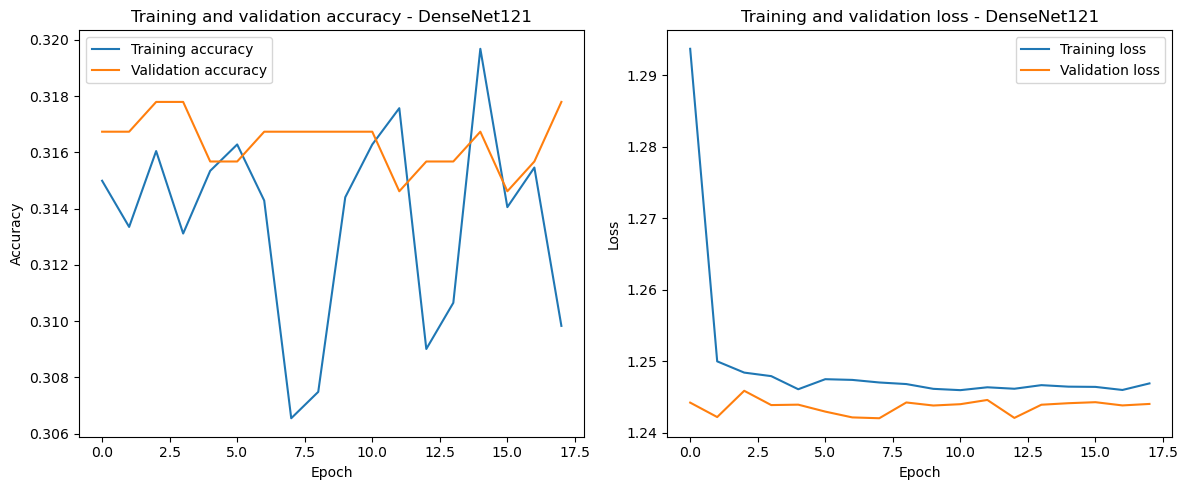

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(denseNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(denseNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - DenseNet121")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(denseNet_history.history["loss"], label="Training loss")
axs[1].plot(denseNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - DenseNet121")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [54]:
# Save trained model
denseNet_model.save("denseNet_model.h5")

# Save history
with open("denseNet_history.pkl", "wb") as f:
    pkl.dump(denseNet_history.history, f)

#### Testing EfficientNetB7 model


In [55]:
# Load the ResNet50 model
base_efficientNet_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_efficientNet_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_efficientNet_model.output
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Flatten(name="flatten")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
# x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
efficientNet_model = Model(inputs=base_efficientNet_model.input, outputs=predictions)

# Compile model
efficientNet_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# efficientNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [56]:
# Train the model
efficientNet_history = efficientNet_model.fit(
    train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[early_stopping]
)

Epoch 1/100
533/533 [==============================] - 98s 159ms/step - loss: 1.2993 - accuracy: 0.3138 - val_loss: 1.2455 - val_accuracy: 0.3157
Epoch 2/100
533/533 [==============================] - 81s 153ms/step - loss: 1.2492 - accuracy: 0.3190 - val_loss: 1.2455 - val_accuracy: 0.3157
Epoch 3/100
533/533 [==============================] - 82s 154ms/step - loss: 1.2479 - accuracy: 0.3165 - val_loss: 1.2441 - val_accuracy: 0.3157
Epoch 4/100
533/533 [==============================] - 82s 153ms/step - loss: 1.2481 - accuracy: 0.3184 - val_loss: 1.2442 - val_accuracy: 0.3146
Epoch 5/100
533/533 [==============================] - 82s 154ms/step - loss: 1.2479 - accuracy: 0.3148 - val_loss: 1.2424 - val_accuracy: 0.3178
Epoch 6/100
533/533 [==============================] - 81s 152ms/step - loss: 1.2463 - accuracy: 0.3184 - val_loss: 1.2440 - val_accuracy: 0.3167
Epoch 7/100
533/533 [==============================] - 82s 153ms/step - loss: 1.2472 - accuracy: 0.3103 - val_loss: 1.2442 -

In [57]:
# Save the trained model
efficientNet_model.save("efficientNet_model.h5")

# Save the history
with open("efficientNet_history.pkl", "wb") as f:
    pkl.dump(efficientNet_history.history, f)

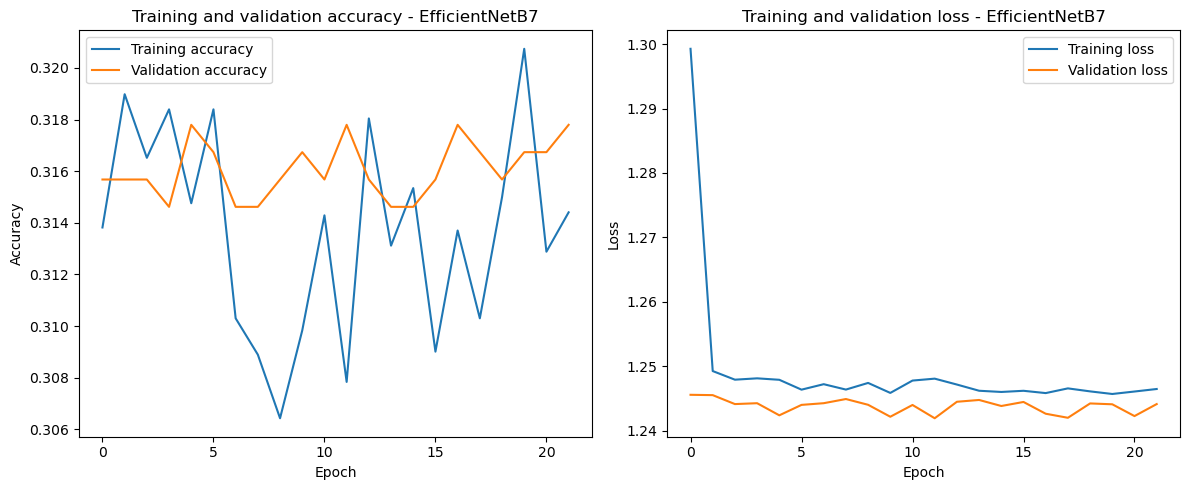

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(efficientNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(efficientNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - EfficientNetB7")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(efficientNet_history.history["loss"], label="Training loss")
axs[1].plot(efficientNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - EfficientNetB7")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

#### Testing custom CNN model

In [59]:
# # Custom CNN architecture
# custom_model = Sequential(
#     [
#         Conv2D(32, (3, 3), activation="relu", input_shape=(img_size, img_size, 3)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(512, activation="relu"),
#         Dropout(0.5),
#         Dense(num_classes, activation="softmax"),
#     ]
# )

# # Compile the model
# custom_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# # custom_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [60]:
# # Train the model
# custom_CNN_history = custom_model.fit(
#     train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[early_stopping]
# )

In [61]:
# # Save the trained model
# custom_model.save("custom_CNN_model.h5")

In [62]:
# plt.plot(custom_CNN_history.history["accuracy"], label="Training accuracy")
# plt.plot(custom_CNN_history.history["val_accuracy"], label="Validation accuracy")
# plt.title("Training and validation accuracy - Custom CNN")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

#### Evaluate models


In [63]:
# Table comparing the performance of models
resNet_accuracy = resNet_history.history["accuracy"][-1]
resNet_val_accuracy = resNet_history.history["val_accuracy"][-1]
denseNet_accuracy = denseNet_history.history["accuracy"][-1]
denseNet_val_accuracy = denseNet_history.history["val_accuracy"][-1]
efficientNet_accuracy = efficientNet_history.history["accuracy"][-1]
efficientNet_val_accuracy = efficientNet_history.history["val_accuracy"][-1]
# custom_CNN_accuracy = custom_CNN_history.history["accuracy"][-1]
# custom_CNN_val_accuracy = custom_CNN_history.history["val_accuracy"][-1]

# resNet_f1 = resNet_history.history["f1_m"][-1]
# resNet_val_f1 = resNet_history.history["val_f1_m"][-1]
# denseNet_f1 = denseNet_history.history["f1_m"][-1]
# denseNet_val_f1 = denseNet_history.history["val_f1_m"][-1]
# efficientNet_f1 = efficientNet_history.history["f1_m"][-1]
# efficientNet_val_f1 = efficientNet_history.history["val_f1_m"][-1]
# custom_CNN_f1 = custom_CNN_history.history["f1_m"][-1]
# custom_CNN_val_f1 = custom_CNN_history.history["val_f1_m"][-1]

model_comparison = pd.DataFrame(
    {
        "Model": ["ResNet50V2", "DenseNet121", "EfficientNetB7"],
        "Train Accuracy": [resNet_accuracy, denseNet_accuracy, efficientNet_accuracy],
        "Validation Accuracy": [resNet_val_accuracy, denseNet_val_accuracy, efficientNet_val_accuracy],
        # "Training F1 Score": [resNet_f1, denseNet_f1, custom_CNN_f1, efficientNet_f1],
        # "Validation F1 Score": [resNet_val_f1, denseNet_val_f1, custom_CNN_val_f1, efficientNet_val_f1],
    }
)

model_comparison

,Model,Train Accuracy,Validation Accuracy
0,ResNet50V2,0.863679,0.352754
1,DenseNet121,0.309831,0.317797
2,EfficientNetB7,0.314406,0.317797


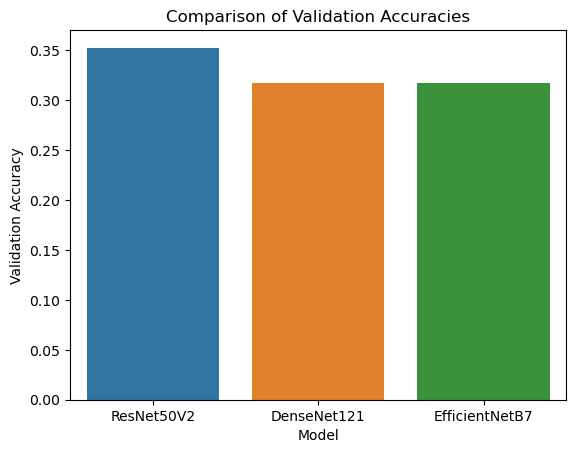

In [64]:
sns.barplot(x="Model", y="Validation Accuracy", data=model_comparison)
plt.title("Comparison of Validation Accuracies")
plt.show()